
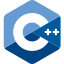
<br>

<div style="text-align:center; font-size:200%;">
 <b>GoF: Strategy Pattern</b>
</div>
<br/>
<div style="text-align:center; font-size:120%;">Dr. Matthias Hölzl</div>
<br/>
<div style="text-align:center;">Coding-Akademie München</div>
<br/>
<!-- 10 GoF Strategy Pattern.ipynb -->
<!-- slides/module_450_design_patterns/topic_200_strategy.cpp -->


### Zweck

- Austauschbare Algorithmen / austauschbares Verhalten
- Algorithmen unabhängig von Klassen, die sie verwenden


### Auch bekannt als

Policy


### Motivation

- Wir wollen einen Text in einem Feld mit begrenzter Breite darstellen
- Dafür gibt es verschiedene Möglichkeiten:
  - Abschneiden nach einer bestimmten Anzahl von Zeichen (mit/ohne Ellipse)
  - Umbruch nach einer bestimmten Anzahl von Zeichen
    - Umbruch mitten im Wort
    - Umbruch bei Leerzeichen (greedy/dynamische Programmierung)


## Struktur

<img src="img/pat_strategy.svg"
     style="display:block;margin:auto;width:80%"/>


## Teilnehmer

- `Strategy`
  - gemeinsames Interface für alle unterstützten Algorithmen
- `ConcreteStrategy`
  - implementiert den Algorithmus
- `Context`
  - wird mit einem `ConcreteStrategy`-Objekt konfiguriert
  - kennt sein `Strategy`-Objekt
  - optional: Interface, das der Strategie Zugriff die Kontext-Daten ermöglicht

In [ ]:
#include <iostream>

In [ ]:
class Strategy {
public:
    virtual ~Strategy() = default;

    virtual float AlgorithmInterface() = 0;
};

In [ ]:
#include <memory>

In [ ]:
class Context{
public:
    Context(std::unique_ptr<Strategy> strategy) : strategy_(std::move(strategy)) {}

    float ContextInterface() { return strategy_->AlgorithmInterface(); }

    void SetStrategy(std::unique_ptr<Strategy> strategy) {
        strategy_ = std::move(strategy);
    }

private:
    std::unique_ptr<Strategy> strategy_;
};

In [ ]:
class ConcreteStrategyA : public Strategy {
public:
    float AlgorithmInterface() override {
        return 1.5;
    }
};

In [ ]:
class ConcreteStrategyB : public Strategy {
public:
    float AlgorithmInterface() override {
        return 2.0;
    }
};

In [ ]:
Context context{std::make_unique<ConcreteStrategyA>()};

In [ ]:
std::cout << "Strategy A: " << context.ContextInterface() << "\n";

In [ ]:
context.SetStrategy(std::make_unique<ConcreteStrategyB>());

In [ ]:
std::cout << "Strategy B: " << context.ContextInterface() << "\n";


### Interaktionen

- Strategie und Kontext interagieren, um den gewählten Algorithmus zu implementieren.
  - Kontext kann Daten an Strategie übergeben
  - Kontext kann sich selber an Strategie übergeben
- Ein Kontext leitet Anfragen seiner Clients an seine Strategie weiter. [...]


### Implementierung

- `ConcreteStrategy` benötigt effizienten Zugriff auf alle benötigten Daten
- ...


## Beispielcode: Textumbruch für ein Blog

In [ ]:
class TextWrapStrategy {
public:
    TextWrapStrategy() = default;
    virtual ~TextWrapStrategy() = default;

    virtual std::vector<std::string> Wrap(const std::string& text, int width) = 0;
};

In [ ]:
class TruncationStrategy : public TextWrapStrategy {
public:
    std::vector<std::string> Wrap(const std::string& text, int width) override {
        if (text.size() <= width) {
            return {text};
        }
        return {text.substr(0, width - 3) + "..."};
    }
};

In [ ]:
class BreakAnywhereStrategy : public TextWrapStrategy {
public:
    std::vector<std::string> Wrap(const std::string& text, int width) override {
        std::string remainingText{text};
        std::vector<std::string> lines;
        while (remainingText.size() > width) {
            lines.push_back(remainingText.substr(0, width));
            remainingText = remainingText.substr(width);
        }
        lines.push_back(remainingText);
        return lines;
    }
};

In [ ]:
class BreakOnSpaceStrategy : public TextWrapStrategy {
public:
    std::vector<std::string> Wrap(const std::string& text, int width) override {
        std::vector<std::string> lines;
        std::string remainingText{text};
        while (remainingText.size() > width) {
            auto pos = remainingText.find_last_of(' ', width);
            if (pos == std::string::npos) {
                pos = width;
            }
            lines.push_back(remainingText.substr(0, pos));
            remainingText = remainingText.substr(pos + 1);
        }
        lines.push_back(remainingText);
        return lines;
    }
};

In [ ]:
class BlogPost {
public:
    BlogPost(
        const std::string& author, const std::string& title, const std::string& text)
        : author_{author}, title_{title}, text_{text} {}

    const std::string& GetAuthor() const { return author_; }
    const std::string& GetTitle() const { return title_; }
    const std::string& GetText() const { return text_; }

private:
    std::string author_;
    std::string title_;
    std::string text_;
};

In [ ]:
class Blog {
public:
    Blog(std::unique_ptr<TextWrapStrategy> strategy) : strategy_{std::move(strategy)} {}

    void Print(int width) {
        for (const auto& post : posts_) {
            std::cout << std::string(width, '-') << "\n";
            std::cout << "Title: " << post.GetTitle() << "\n";
            std::cout << "Author: " << post.GetAuthor() << "\n";
            for (const auto& line : strategy_->Wrap(post.GetText(), width)) {
                std::cout << line << "\n";
            }
            std::cout << std::string(width, '-') << "\n";
        }
    }

    void AddPost(const BlogPost& post) { posts_.push_back(post); }

    void SetStrategy(std::unique_ptr<TextWrapStrategy> strategy) {
        strategy_ = std::move(strategy);
    }

private:
    std::vector<BlogPost> posts_;
    std::unique_ptr<TextWrapStrategy> strategy_;
};

In [ ]:
std::string firstPost{"This is my first post. This is my first post. This is my first "
                      "post. This is my first post. This is my first post. This is my "
                      "first post. This is my first post. This is my first post. "};
std::string secondPost{
    "This is my second post. This is my second post. This is my second post. This is "
    "my second post. This is my second post. This is my second post. This is my second "
    "post. This is my second post. This is my second post. This is my second post. "
    "This is my second post. This is my second post. "}

In [ ]:
Blog blog{std::make_unique<TruncationStrategy>()};

In [ ]:
blog.AddPost({"John Doe", "My first post", firstPost});
blog.AddPost({"Jane Doe", "My second post", secondPost});

In [ ]:
blog.Print(40);

In [ ]:
blog.SetStrategy(std::make_unique<BreakAnywhereStrategy>());

In [ ]:
blog.Print(40);

In [ ]:
blog.SetStrategy(std::make_unique<BreakOnSpaceStrategy>());

In [ ]:
blog.Print(40);


### Anwendbarkeit

- Konfiguration von Objekten mit einer von mehreren Verhaltensweisen
- Verschiedene Varianten eines Algorithmus
- Kapseln von Daten mit Algorithmus (Client muss Daten nicht kennen)
- Vermeidung von bedingten Anweisungen zur Auswahl eines Algorithmus


### Konsequenzen

- Familien wiederverwendbarer, verwandter Algorithmen
- Alternative zu Vererbung
- Auswahl einer Strategie ohne bedingte Anweisungen
- Context/Clients muss die möglichen Strategien kennen
- Kommunikations-Overhead zwischen Strategie und Kontext
- Erhöhte Anzahl von Objekten


### C++ Implementierungs-Tipp

In C++ kann das Strategy Pattern oft einfach durch ein Funktions-Objekt als
Member implementiert werden:

In [ ]:
class FunBlog {
public:
    using Strategy = std::function<std::vector<std::string>(const std::string&, int)>;

    FunBlog(Strategy strategy) : strategy_{std::move(strategy)} {}

    void Print(int width) {
        for (const auto& post : posts_) {
            std::cout << std::string(width, '-') << "\n";
            std::cout << "Title: " << post.GetTitle() << "\n";
            std::cout << "Author: " << post.GetAuthor() << "\n";
            for (const auto& line : strategy_(post.GetText(), width)) {
                std::cout << line << "\n";
            }
            std::cout << std::string(width, '-') << "\n";
        }
    }

    void AddPost(const BlogPost& post) { posts_.push_back(post); }
    void SetStrategy(Strategy strategy) { strategy_ = std::move(strategy); }

private:
    std::vector<BlogPost> posts_;
    Strategy strategy_;
};

In [ ]:
std::vector<std::string> TruncateLines(const std::string& text, int width) {
    if (text.size() <= width) {
        return {text};
    }
    return {text.substr(0, width - 3) + "..."};
}


- Hier haben wir eine Funktion `TruncateLines()` definiert, die die gleiche
  Funktionalität hat wie unsere `TruncationStrategy`
- Allerdings ist sie jetzt als freie Funktion definiert

In [ ]:
FunBlog blog{TruncateLines};

In [ ]:
blog.AddPost({"John Doe", "My first post", firstPost});
blog.AddPost({"Jane Doe", "My second post", secondPost});

In [ ]:
blog.Print(40);

In [ ]:
#include <algorithm>

In [ ]:
blog.SetStrategy(
    [](const std::string& text, int width) -> std::vector<std::string> {
        if (text.size() <= width) {
            return {text};
        }
        return {text.substr(0, width - 3) + "..."};
    });

In [ ]:
blog.Print(40);


## Mini-Workshop: Vorhersagen

Sie wollen ein System schreiben, das Vorhersagen für Aktienkurse treffen kann.

Schreiben Sie dazu eine Klasse `Predictor` mit einer Methode

```cpp
virtual float Predict(const std::vector<float>& values) const
```

Verwenden Sie das Strategy Pattern, um mindestens zwei verschiedene
Vorhersage-Varianten zu ermöglichen:

- Die Vorhersage ist der Mittelwert aller Werte aus `values`
- Die Vorhersage ist der letzte Wert in `values` (oder 0, wenn `values` leer ist)

Testen Sie Ihre Implementierung mit einigen Beispieldaten.